In [3]:
import Pkg
Pkg.activate("../../../FinancialPlanner/_wip/TCVAR")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner\_wip\TCVAR`


In [4]:
using Revise
using Plots
using MCMCChains
using StatsPlots

In [5]:
includet("TCVAR_model.jl")
includet("carter_kohn_algorythm.jl")
includet("model_visualisation.jl")
includet("utills.jl")
includet("gibbs_steps.jl")
includet("gibbs_sampler.jl")

In [6]:
    true_var_coeff = [.3 .1;  .4 .6]
    true_trend_covariance =  diagm([.02/10, .01/10] .^2) 

    p = -0.7 * .015 * 0.011

    true_cycle_covariance = [(.015)^2 p
                             p (.011)^2]

     
    true_initial_trend_mean = [.02, .01]
    true_initial_trend_covariance = Matrix(I, 2,2)
    true_initial_cycle_mean = [.0, .0]
    true_initial_cycle_covariance = [(.015)^2 0
                                      0 (.011)^2]
                                   
    
    true_model = tc_var(true_var_coeff, 
                        true_trend_covariance, 
                        true_cycle_covariance, 
                        true_initial_trend_mean, 
                        true_initial_cycle_mean, 
                        true_initial_trend_covariance, 
                        true_initial_cycle_covariance)


    initial_state = [.02, .008]
    true_states, observations= sample(true_model,  [.02, .01, .0, .0], 5100)

    n_presample = 100

    presample_data, data = observations[1:n_presample,:], observations[n_presample+1:end,:]

    true_states = true_states[n_presample+1:end,:]
  
 
 

5000×4 Matrix{Float64}:
  0.0058228   0.0194768   0.00103051   0.0133396
  0.0074483   0.0181687   0.00330939   0.00324125
  0.00931443  0.0182739   0.0102597   -0.00983452
  0.00895329  0.0174793   0.00456001  -0.0159374
  0.0123952   0.01883    -0.028726     0.0250379
  0.0122609   0.0173758   0.00466143  -0.0124247
  0.0126212   0.0173625   0.00522472  -0.0148659
  0.0100539   0.0186023   0.00650396   0.0015827
  0.00622934  0.019701   -0.014209     0.00834038
  0.00939125  0.0181707  -0.0144065    0.00549358
  ⋮                                   
 -0.119812    0.0364125  -0.0022616    0.00110476
 -0.122675    0.0352825   0.00834398  -0.00920378
 -0.121418    0.034529   -0.0125428   -0.0123845
 -0.12261     0.0340975   0.0161466   -0.0220188
 -0.123079    0.0341745   0.00742589  -0.0176595
 -0.123531    0.0334463  -0.0181531   -0.000857309
 -0.125424    0.033412   -0.00851341  -0.00594808
 -0.120249    0.0337299  -0.00369169  -0.0133508
 -0.12027     0.0362528  -0.0217195   -0.01153

In [146]:
display(mean(presample_data[:,1], dims=1)[1])
display(mean(presample_data[:,2] - presample_data[:,1], dims=1)[1])
display(std(presample_data, dims=1))

0.03124584000404616

0.014885905205037015

1×2 Matrix{Float64}:
 0.0190031  0.018137

In [147]:
mean(data, dims=1)

1×2 Matrix{Float64}:
 -0.00623302  0.0616072

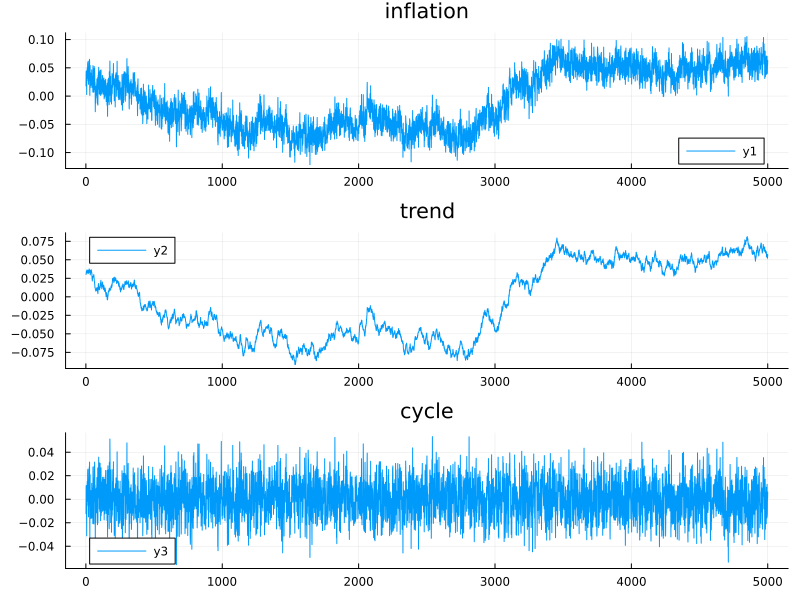

In [148]:
plot_variable_states(data[:, 1], true_states[:, [1,3]], ["inflation" "trend" "cycle"])

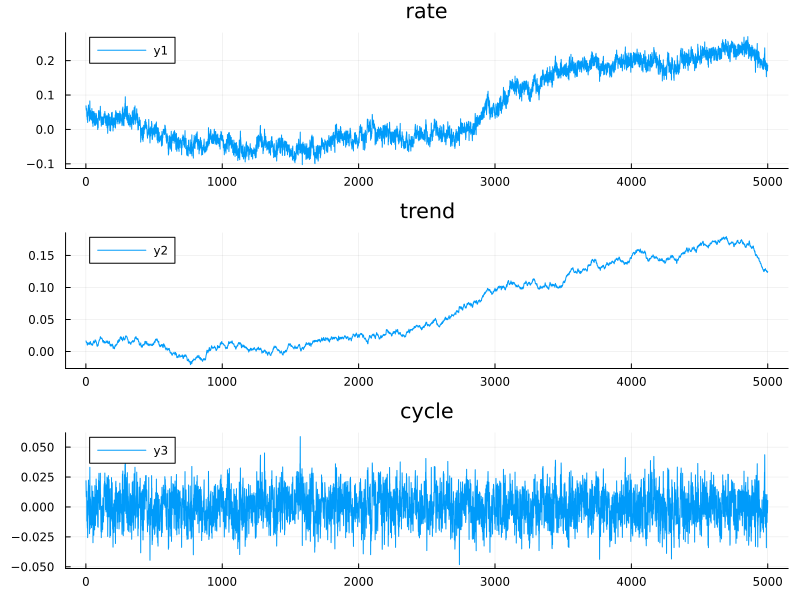

In [149]:
plot_variable_states(data[:, 2], true_states[:, [2,4]], ["rate" "trend" "cycle"])

In [150]:
priors = (
        initial_trend_mean = [mean(presample_data[:,1], dims=1)[1], mean(presample_data[:,2] - presample_data[:,1], dims=1)[1]],
        trend_covariance_df = 100,
        trend_covariance_mean = true_trend_covariance * (100 + 2 +1) #diagm([2, 1].^2/100) * (100 + 2 +1),
        )

(initial_trend_mean = [0.03124584000404616, 0.014885905205037015], trend_covariance_df = 100, trend_covariance_mean = [0.000412 0.0; 0.0 0.000103])

In [151]:
state_smoothed_samples, trend_covariance_samples = gibs_sampler(data, priors, 1_000)

state_smoothed_mean, state_smoothed_lower, state_smoothed_upper = compute_posterior_statistics(state_smoothed_samples, credible_level=0.95)  

([0.03774317241621415 0.01254346002348106 -0.019796065884441334 0.018238894669951235; 0.03858756204465247 0.012666772118974727 0.003212193068956375 0.008767015286185195; … ; 0.053542082224530385 0.13007470879190222 0.0008482332658612417 -0.005037408211377286; 0.054600112741699146 0.13030148697344157 0.008570828234542433 0.001913793711089935], [0.026908218519873173 0.0024527518815704746 -0.03021604780370788 0.00501296969388788; 0.02814665628530034 0.0027275880731289265 -0.006451593851695028 -0.0036478728683091684; … ; 0.04238968219886907 0.1202975242988253 -0.009848414581870225 -0.016589361383275738; 0.04319402089712955 0.12077533634835068 -0.0022453877269773648 -0.010307295622765526], [0.04819384362285055 0.02239475077619217 -0.008916350380041647 0.030463376452447333; 0.04832774738983797 0.022461192410023215 0.013624538687086674 0.020520914897501526; … ; 0.06431598395853413 0.13988779569691828 0.011937433343675072 0.007016255348738183; 0.06554277443278105 0.1408361079752077 0.019970021

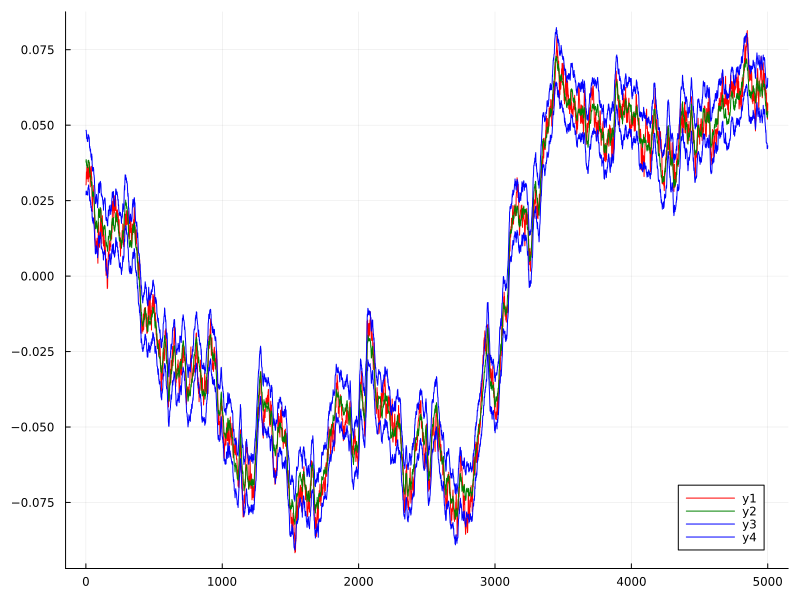

In [152]:
st = 1
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_smoothed_mean[:,st], color="green" )
plot!(state_smoothed_lower[:,st], color="blue")
plot!(state_smoothed_upper[:,st], color="blue")

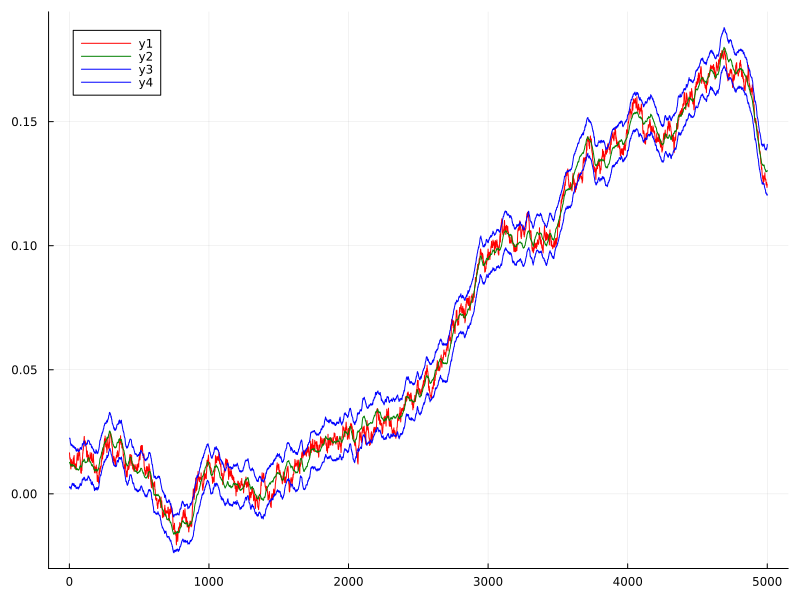

In [153]:
st = 2
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_smoothed_mean[:,st], color="green" )
plot!(state_smoothed_lower[:,st], color="blue")
plot!(state_smoothed_upper[:,st], color="blue")

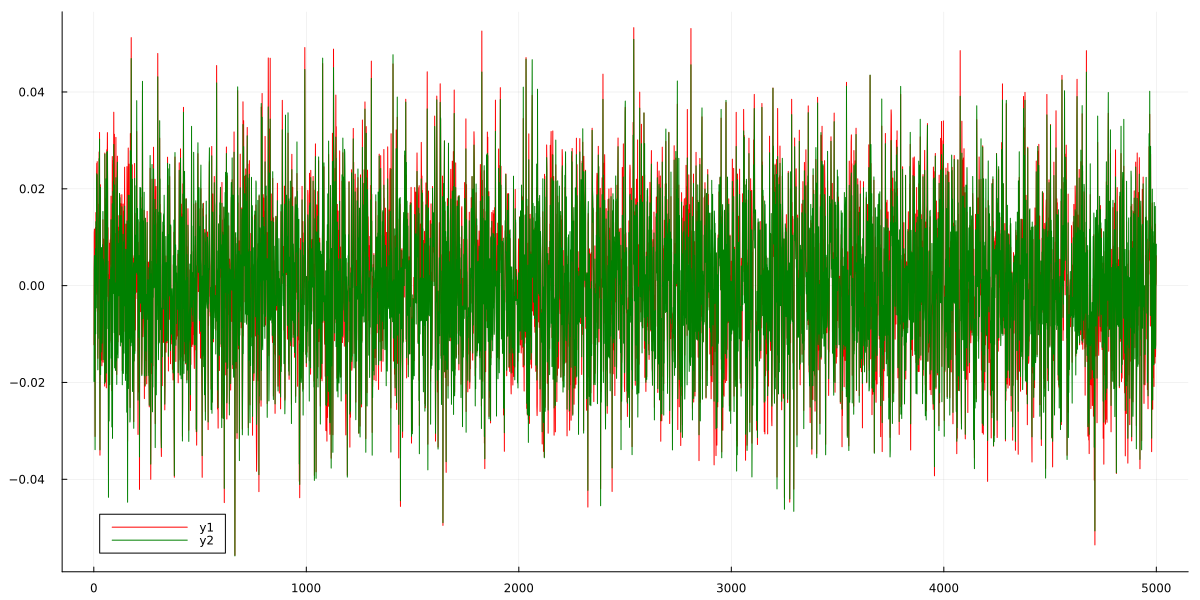

In [156]:
st = 3
plot(true_states[:,st]; color="red", size= (1200, 600))
plot!(state_smoothed_mean[:,st], color="green" )
#plot!(state_smoothed_lower[:,st], color="blue")
#plot!(state_smoothed_upper[:,st], color="blue")

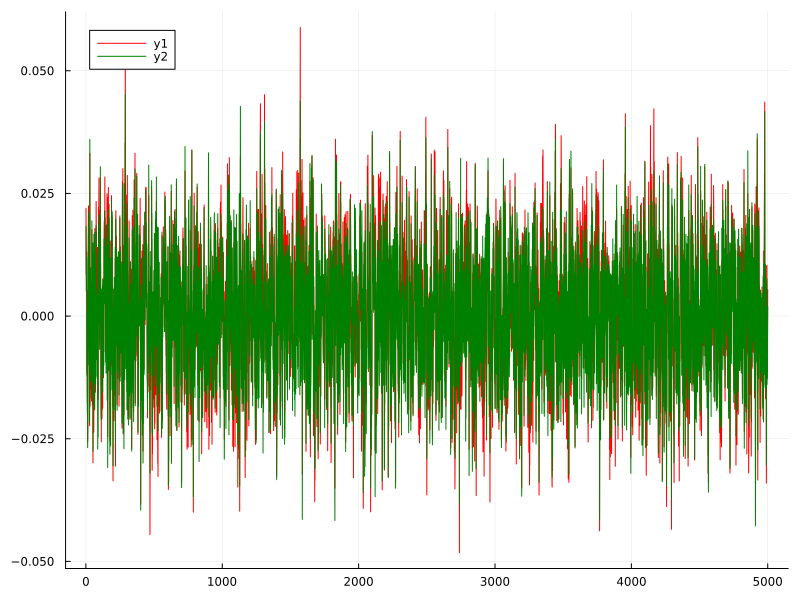

In [157]:
st = 4
plot(true_states[:,st]; color="red", size= (800, 600))

plot!(state_smoothed_mean[:,st], color="green" )
#plot!(state_smoothed_lower[:,st], color="blue")
#plot!(state_smoothed_upper[:,st], color="blue")

In [158]:
Y = true_states[:,[1,2]]
e  = diff(Y, dims=1)
true_var = e' * e * 1/(size(Y,1)-1)
display(diag(true_var))
display(diag(true_var).^.5)

2-element Vector{Float64}:
 3.966474990284871e-6
 1.0148744591132754e-6

2-element Vector{Float64}:
 0.001991601112242326
 0.0010074097771578731

In [159]:
summarystats(trend_covariance_samples)

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

       Στ[1]    0.0000    0.0000    0.0000     6.8320    46.0624    1.1744     ⋯
       Στ[2]    0.0000    0.0000    0.0000    27.0710    55.4025    1.0659     ⋯
       Στ[3]    0.0000    0.0000    0.0000    27.0710    55.4025    1.0659     ⋯
       Στ[4]    0.0000    0.0000    0.0000    17.8758    50.7298    1.1616     ⋯
                                                                1 column omitted


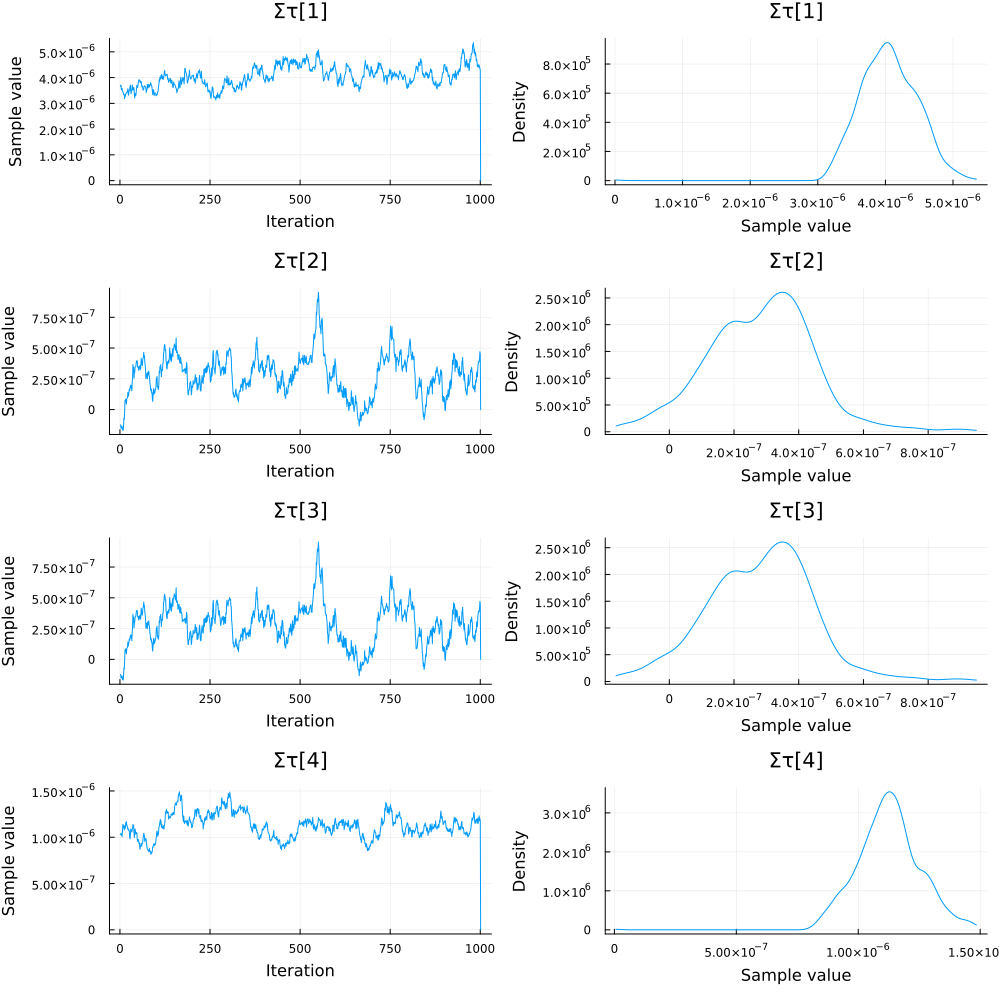

In [160]:
plot(trend_covariance_samples)

In [161]:
beta_mean_prior, beta_var_prior = minnesota_priors([0.015, 0.011] .^.5 , λ1=0.2, λ2=1., λ3=1.0, p=1, zero_ownlag=[true, true])


([0.0, 0.0, 0.0, 0.0], [0.04000000000000001, 0.029333333333333347, 0.05454545454545455, 0.04000000000000001])

In [162]:
d_post = size(data, 1) - 1 + priors.trend_covariance_df

post_dist = covariance_posterior(true_states[:,[1,2]], priors.trend_covariance_mean, d_post)

InverseWishart{Float64, PDMats.PDMat{Float64, Matrix{Float64}}}(
df: 5099.0
Ψ: [0.02024040847643407 0.00010709367963333741; 0.00010709367963333741 0.005176357421107264]
)


In [163]:
true_var + priors.trend_covariance_mean

2×2 Matrix{Float64}:
 0.000415966  2.1423e-8
 2.1423e-8    0.000104015

In [164]:
cov_posterior = zeros(10_000, 2)

for n in 1:10_000
  cov_posterior[n,:,:] = diag(rand(post_dist))
end


display(mean(cov_posterior, dims=1) .* 100)
display(mean(cov_posterior, dims=1).^.5 *10) 
display(mode(cov_posterior[1]).^.5 * 10) 
display(mode(cov_posterior[2]).^.5 * 10) 

1×2 Matrix{Float64}:
 0.000397199  0.000101596

1×2 Matrix{Float64}:
 0.0199299  0.0100795

0.020026099072783923

0.02034104050992982

In [165]:
diag(true_trend_covariance) .^.5 * 10

2-element Vector{Float64}:
 0.02
 0.01

In [166]:
true_trend_covariance .^.5 .*10

2×2 Matrix{Float64}:
 0.02  0.0
 0.0   0.01

In [167]:
diag(priors.trend_covariance_mean) .^.5 *10

2-element Vector{Float64}:
 0.20297783130184438
 0.10148891565092219

In [168]:
stds = zeros(50_000, 2)


for n in 1:50_000
    stds[n,:] = diag(rand(InverseWishart(priors.trend_covariance_df, priors.trend_covariance_mean)))
end

display(mean(stds, dims=1).^.5 .*10)
display(mode(stds[1]) ^.5 * 10) 
display(mode(stds[2]) ^.5 * 10) 


1×2 Matrix{Float64}:
 0.0206075  0.0103121

0.020738318385649324

0.02089420612085936

In [169]:
stds = std.(eachcol(true_states[:,[3, 4]]))

2-element Vector{Float64}:
 0.015363399275890217
 0.013662445885669623

In [170]:
stds[2]/stds[1] * 0.2

0.17785706978416035

In [191]:
φ, Ω =  minnesota_priors([.015, .011], λ1=0.2, λ2=1., λ3=1.0, p=1, zero_ownlag=[true, true])

display(reshape(φ, 2, 2))

Ω

2×2 Matrix{Float64}:
 0.0  0.0
 0.0  0.0

4-element Vector{Float64}:
 0.04000000000000001
 0.021511111111111113
 0.07438016528925621
 0.04000000000000001

In [192]:
(1 ./ Ω)' *  Ω

4.0

In [193]:
true_var_coeff

2×2 Matrix{Float64}:
 0.3  0.1
 0.4  0.6

In [194]:
Y, X = prepare_var_data(true_states[:, [3,4]], 1)

(inv(X'X)*X'*Y)'

2×2 adjoint(::Matrix{Float64}) with eltype Float64:
 0.282908  0.0876358
 0.410691  0.633459

In [195]:
posterior_beta_coefficient(Y, X, reshape(φ, 2, 2), reshape((1 ./ Ω), 2, 2))'

2×2 adjoint(::Matrix{Float64}) with eltype Float64:
  0.099568   -0.178807
 -0.0066951   0.0268831

In [196]:
posterior_beta_coefficient(Y, X, reshape(φ, 2, 2), zeros(2,2))'

2×2 adjoint(::Matrix{Float64}) with eltype Float64:
 0.282908  0.0876358
 0.410691  0.633459

In [197]:
display(true_var_coeff)
display(true_cycle_covariance)

2×2 Matrix{Float64}:
 0.3  0.1
 0.4  0.6

2×2 Matrix{Float64}:
  0.000225   -0.0001155
 -0.0001155   0.000121

In [29]:
T = 1_500

result = zeros(T, 2)

result[1,:] = [0., 0.]

for t in 2:T
    result[t, :] = true_var_coeff * result[t-1, :] + rand(MvNormal(zeros(2), true_cycle_covariance))
end

Y, X = prepare_var_data(result, 1)



2×2 adjoint(::Matrix{Float64}) with eltype Float64:
 0.290193  0.0983927
 0.417327  0.607216

In [52]:
true_cycle_covariance = diagm([.02, .09].^2)

2×2 Matrix{Float64}:
 0.0004  0.0
 0.0     0.0081

In [60]:
display((inv(X'*X)*X'*Y)')

display(kron(true_cycle_covariance, inv(X'X)))

2×2 adjoint(::Matrix{Float64}) with eltype Float64:
 0.290193  0.0983927
 0.417327  0.607216

4×4 Matrix{Float64}:
 0.00143079  0.0007644   0.0        0.0
 0.0007644   0.00192925  0.0        0.0
 0.0         0.0         0.0289736  0.0154791
 0.0         0.0         0.0154791  0.0390674

In [54]:
true_var_coeff

2×2 Matrix{Float64}:
 0.3  0.1
 0.4  0.6

In [55]:
prior_var = diag(true_cycle_covariance)
λ = 0.1
Ω = [λ^2, λ^2] ./ prior_var
Ω = Diagonal(Ω)
Ω_inv = inv(Ω)

β_hat = posterior_beta_coefficient_mean(Y, X, zeros(2,2), Ω_inv)

V_hat = posterior_beta_coefficient_var(X, true_cycle_covariance, Ω_inv)

beta_post = rand(MvNormal(vec(β_hat), V_hat), 2000)

quantile(Chains(beta_post'))

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

     param_1    0.1700    0.2125    0.2336    0.2551    0.2947
     param_2   -0.0215    0.0041    0.0165    0.0295    0.0570
     param_3   -0.0981    0.1040    0.2002    0.3010    0.5026
     param_4   -0.0554    0.0594    0.1189    0.1815    0.2988


In [56]:
prior_var = diag(true_cycle_covariance)
λ = 0.2
Ω = [λ^2, λ^2] ./ prior_var
Ω = Diagonal(Ω)
Ω_inv = inv(Ω)

β_hat = posterior_beta_coefficient_mean(Y, X, zeros(2,2), Ω_inv)

V_hat = posterior_beta_coefficient_var(X, true_cycle_covariance, Ω_inv)

beta_post = rand(MvNormal(vec(β_hat), V_hat), 2000)

quantile(Chains(beta_post'))

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

     param_1    0.1966    0.2395    0.2640    0.2867    0.3326
     param_2   -0.0138    0.0284    0.0486    0.0692    0.1064
     param_3   -0.0416    0.1856    0.2942    0.3939    0.6063
     param_4    0.0227    0.2069    0.3087    0.4032    0.5849


In [57]:
prior_var = diag(true_cycle_covariance)
λ = 0.4
Ω = [λ^2, λ^2] ./ prior_var
Ω = Diagonal(Ω)
Ω_inv = inv(Ω)

β_hat = posterior_beta_coefficient_mean(Y, X, zeros(2,2), Ω_inv)

V_hat = posterior_beta_coefficient_var(X, true_cycle_covariance, Ω_inv)

beta_post = rand(MvNormal(vec(β_hat), V_hat), 2000)

quantile(Chains(beta_post'))

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

     param_1    0.2112    0.2554    0.2790    0.3042    0.3515
     param_2    0.0011    0.0521    0.0800    0.1052    0.1547
     param_3    0.0517    0.2593    0.3673    0.4787    0.6912
     param_4    0.1519    0.3702    0.4864    0.6069    0.8505


In [58]:
prior_var = diag(true_cycle_covariance)
λ = 0.8
Ω = [λ^2, λ^2] ./ prior_var
Ω = Diagonal(Ω)
Ω_inv = inv(Ω)

β_hat = posterior_beta_coefficient_mean(Y, X, zeros(2,2), Ω_inv)

V_hat = posterior_beta_coefficient_var(X, true_cycle_covariance, Ω_inv)

beta_post = rand(MvNormal(vec(β_hat), V_hat), 2000)

quantile(Chains(beta_post'))

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

     param_1    0.2156    0.2620    0.2885    0.3151    0.3639
     param_2    0.0117    0.0639    0.0934    0.1239    0.1770
     param_3    0.0473    0.2801    0.4101    0.5250    0.7295
     param_4    0.1983    0.4504    0.5717    0.7056    0.9312


uncoditional variance

In [10]:
uv = inv(I(4) - kron(true_var_coeff, true_var_coeff)) * vec(true_cycle_covariance)
reshape(uv, 2, 2)

2×2 Matrix{Float64}:
  0.000242794  -9.71144e-5
 -9.71144e-5    0.000176925

In [34]:
kron(I(2), I(2)) * vec(true_cycle_covariance)

4-element Vector{Float64}:
  0.000225
 -0.00011549999999999997
 -0.00011549999999999997
  0.00012099999999999999

In [35]:
uv = inv(I(4) - kron(zeros(2,2), zeros(2,2))) * vec(true_cycle_covariance)

4-element Vector{Float64}:
  0.000225
 -0.00011549999999999997
 -0.00011549999999999997
  0.00012099999999999999

In [36]:
kron(zeros(2,2), zeros(2,2))

4×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0